In [1]:
from fastai.text import *

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from torch.nn.functional import cosine_similarity

In [3]:
import scipy

In [3]:
def calc_cat1(answers, truth):
    # (1/n)*(nc+(nu*nc/n))
    n_correct = 0
    n_undecided = 0
    n = len(answers)
    for k, v in enumerate(answers):
        if v == 0.5:
            n_undecided += 1
        else:
            n_correct += (v > 0.5) == truth[k]

    scale = 1.0 / n
    return (n_correct + n_undecided * n_correct * scale) * scale

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device('cuda:0')

In [6]:
df_train = pd.read_pickle('./data_new/pan_14e_cls/train_essays.pickle')
df_test01 = pd.read_pickle('./data_new/pan_14e_cls/test01_essays.pickle')
df_test02 = pd.read_pickle('./data_new/pan_14e_cls/test02_essays.pickle')
df_train

,label,k_doc,u_doc
0,Y,"[ English, my English! xcrlfx Assesing ones ...","In the name of Religion, you can get away wit..."
1,Y,[ English as a world language 1. xcrlfx Intr...,The Decline of the Birth-rate in Sweden A ne...
2,N,[ PART-TIME FATHERS When a relationship has i...,"""Taboo or Not Taboo"" In the article ""Cleanin..."
3,Y,[ Why Are the Young Abandoning Party Politics?...,Granting Homosexual Couples the Right to Adop...
4,N,[ Why do Swedish Women Wait with Having Childr...,Politics and Education On numerous occasions...
...,...,...,...
195,N,[I think I am quite fluent in English. xcrlfx...,Girls and boys in separate classes? xcrlfx ...
196,N,"[ My life, my choice It is forbidden in Swedi...","English, My English! xcrlfx Introduction: I..."
197,N,[When I first got this assignment I got really...,This an essay about my experience from studyin...
198,N,[ Should the US bomb Afghanistan? xcrlfx The...,\tJust a few years ago I felt quite confident ...


In [7]:
len(df_train), len(df_test01), len(df_test02)

(200, 100, 200)

# Build LM

In [8]:
uniq_list = []
for dfi, df in enumerate( [df_train, df_test01, df_test02] ):
    
    for i in range(len(df)):
        
        for doc in df.iloc[i,1]:
            if( doc not in uniq_list ):
                uniq_list.append(doc)
                
        if( df.iloc[i,2] not in uniq_list ):
            uniq_list.append( df.iloc[i,2] )

len(uniq_list)

1119

In [9]:
uniq_list = pd.DataFrame(uniq_list)
uniq_list

,0
0,"English, my English! xcrlfx Assesing ones s..."
1,Due to the increasing violence that we're dail...
2,"An peculiar lady crossed my path, once again!..."
3,"In the name of Religion, you can get away wit..."
4,English as a world language 1. xcrlfx Intro...
...,...
1114,In a country like Sweden the expectations of y...
1115,Canadian Television In Canada there are a wi...
1116,One thing about my English that I find particu...
1117,How does television affect children? xcrlfx...


In [10]:
db = TextLMDataBunch.from_df('./data_new/pan_14e_cls/',
                            train_df=uniq_list[:900], valid_df=uniq_list[900:],
                            text_cols=0)

In [11]:
len( db.vocab.itos )

12304

## Train the LM

In [13]:
learn = language_model_learner(db, AWD_LSTM)

In [14]:
learn.unfreeze()
learn.fit_one_cycle(6)
learn.save("pan-14e.learn", return_path=True)

epoch,train_loss,valid_loss,accuracy,time
0,4.217542,3.596413,0.328147,00:36
1,3.684061,3.412851,0.342893,00:34
2,3.506239,3.341470,0.350505,00:37
3,3.343483,3.309934,0.354147,00:40
4,3.245101,3.295493,0.355629,00:41
5,3.171242,3.292864,0.355978,00:41


WindowsPath('data_new/pan_14e_cls/models/pan-14e.learn.pth')

## Show some text

In [15]:
learn.beam_search("And do your best to", 10)

'And do your best to And do your best to be able to take care of your children ? xcrlfx'

In [16]:
learn.predict( "Oh, if you only would. I'd just love", n_words=20 )

"Oh, if you only would. I'd just love to play and i can watch everything you can do reality . xcrlfx If you bought your spontaneous mind"

# Generate all raw vectors and saves them

In [19]:
def one_doc_embed(learn, doc):
    model = learn.model
    model = model.eval()
    
    pred_enc = model[0]
    doc_enc = model[0].encoder
    
    ids, _ = learn.data.one_item(doc)
    
    with torch.no_grad():
        pred_enc.reset()
        embed = doc_enc(ids).detach()
        pred  = pred_enc(ids)[0][-1].detach()
        
        return {"e":embed, "p":pred}

def pred_raw(learn, df):
    prob_list = []
    label_list = []
    
    for i in tqdm(range(len(df))):
        k_results = []
        for k_doc in df.iloc[i,1]:
            k_results.append( one_doc_embed(learn, k_doc) )

        u_results = one_doc_embed(learn, df.iloc[i,2])
        prob_list.append( {"k":k_results, "u":u_results} )
        label_list.append( df.iloc[i,0] )
        
    return  prob_list, label_list

In [25]:
test_prob, test_label = pred_raw(learn, df_test02)

100%|███████████████████████████████████████████████████████████████████████| 200/200 [02:24<00:00,  1.38it/s]


In [26]:
torch.save( (test_prob, test_label), "./saves/pan14e_test02.torchsave" )

In [4]:
test_prob, test_label = torch.load( "./saves/pan14e_test02.torchsave" )

# Plot all dists

KstestResult(statistic=0.047556257402289775, pvalue=0.2661941732032016)
KstestResult(statistic=0.04205366357069144, pvalue=0.33655071856407714)
KstestResult(statistic=0.024439001264222503, pvalue=0.9165979041842611)
KstestResult(statistic=0.08929302888068077, pvalue=0.0004935214776323749)
KstestResult(statistic=0.10768921829931724, pvalue=2.5404682640339793e-05)
KstestResult(statistic=0.1203577817531306, pvalue=4.759872307413815e-08)
KstestResult(statistic=0.06715872205884674, pvalue=0.03672164363886077)
KstestResult(statistic=0.06736184169812488, pvalue=0.0192732404530106)
KstestResult(statistic=0.15888488633962575, pvalue=3.5393632469293834e-10)
KstestResult(statistic=0.03356150214738038, pvalue=0.6238645237956466)


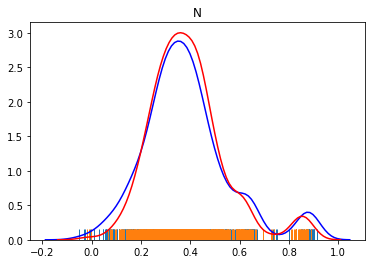

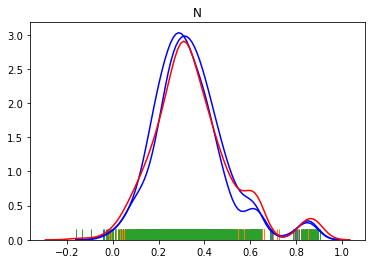

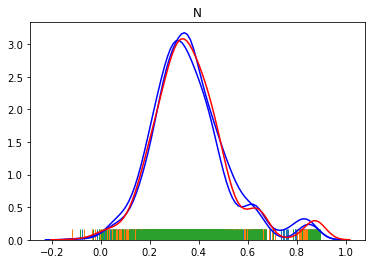

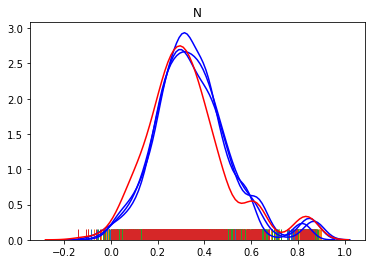

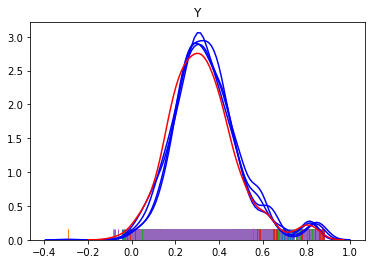

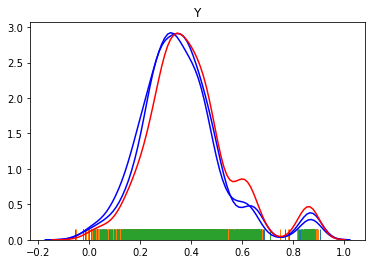

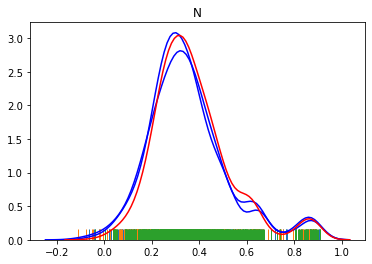

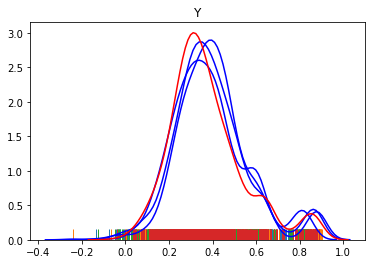

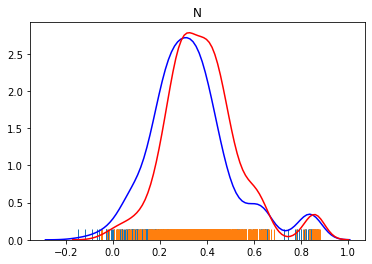

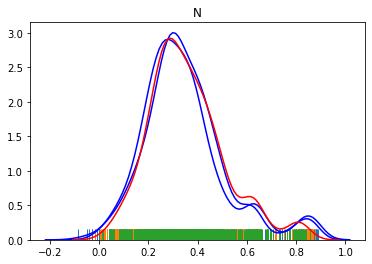

In [42]:
for i in range(10):    
    fig = plt.figure()
    
    for ik in range(len(test_prob[i]["k"])):
        result_k = cosine_similarity(test_prob[i]["k"][ik]["e"][0,1:,:], test_prob[i]["k"][ik]["p"][0,:-1,:], dim=1)
        fig = sns.distplot(result_k.cpu().numpy(), kde=True, rug=True, hist=False, 
                           kde_kws={"color": "blue"} )
    
    result_u = cosine_similarity(test_prob[i]["u"]["e"][0,1:,:], test_prob[i]["u"]["p"][0,:-1,:], dim=1)
    fig = sns.distplot(result_u.cpu().numpy(), kde=True, rug=True, hist=False,
                       kde_kws={"color": "red"})
    
    fig.set_title( test_label[i] )
    fig.figure.savefig(f'./plots/dist_plot/onlyk_{i:03}.png')

# experiment with raw values

In [14]:
truth = np.array(test_label) == "Y"
truth

array([False, False, False, False, ..., False, False, False, False])

In [10]:
result = []
for i in range(len(test_prob)):
#     print(i)
    result_k = torch.mean(test_prob[i]["k"][0]["e"][0,1:,:] - test_prob[i]["k"][0]["p"][0,:-1,:], dim=0, keepdim=True)
    result_u = torch.mean(test_prob[i]["u"]["e"][0,1:,:] - test_prob[i]["u"]["p"][0,:-1,:], dim=0, keepdim=True)
    r = cosine_similarity(result_k, result_u).cpu().item()
    
    result.append(r)
    
result = np.array(result)

In [11]:
result

array([0.228334, 0.440885, 0.544415, 0.393583, ..., 0.25904 , 0.50608 , 0.895595, 0.933412])

In [12]:
pred = result > np.median(result)
pred

array([False,  True,  True,  True, ..., False,  True,  True,  True])

In [15]:
np.sum( pred == truth ) / len(truth)

0.37

In [59]:
len(truth)

200

# Combine doc matrix into giant one so we can do token level

In [17]:
def combine_doc_mat(klist, ulist):
    k_all

torch.Size([894, 400])

# ====================

In [45]:
train_y = ( df_train["label"].to_numpy() == "Y" ).astype(np.int)
# train_y = torch.tensor(train_y).cuda().double()
# train_y = train_y.unsqueeze(dim=-1)

eval_y = ( df_test["label"].to_numpy() == "Y").astype(np.int)
# eval_y = torch.tensor(eval_y).cuda().double()
# eval_y = eval_y.unsqueeze(dim=-1)

# =============================================

In [29]:
class ConcatClas(nn.Module):
    def __init__(self):
        super(ConcatClas, self).__init__()
        layer_1 = []
        layer_1.append( torch.nn.BatchNorm1d(400) )
        layer_1.append( torch.nn.Dropout(0.5) )
        layer_1.append( torch.nn.Linear(400, 1) )
#         layer_1.append( torch.nn.GELU() )
        self.l1 = nn.Sequential(*layer_1)
#         layer_2 = []
#         layer_2.append( torch.nn.BatchNorm1d(32) )
#         layer_2.append( torch.nn.Dropout(0.1) )
#         layer_2.append( torch.nn.Linear(32, 1) )
#         layer_2.append( torch.nn.Sigmoid() )
#         self.l2 = nn.Sequential(*layer_2)
        
    def forward(self, k_dv, u_dv):
#         dvs = torch.cat( (k_dv, u_dv), dim=1 )
        dvs = k_dv - u_dv
        t = self.l1(dvs)
#         t = self.l2(t)
        return t
        

In [30]:
def eval_acc(model, k_dvs, u_dvs, lbl):
    all_pred = []
    loss_list = []
    model.eval()
    with torch.no_grad():
        for i in range( int(len(lbl)/25) ):
#             print("step: " + str(i))
            xk = torch.tensor( k_dvs[(i*25):((i+1)*25), :] ).cuda()
            xu = torch.tensor( u_dvs[(i*25):((i+1)*25), :] ).cuda()
            y_pred = model(xk, xu)
            
            loss = F.binary_cross_entropy_with_logits(input=y_pred, target=lbl[(i*25):((i+1)*25), :])
            loss_list.append(loss.detach().cpu().numpy())
            
            all_pred.append( y_pred.detach().cpu().numpy() )
    all_pred = np.concatenate(all_pred)
    pred_tf = all_pred > np.median(all_pred)
    acc = np.sum( lbl.cpu().numpy() == pred_tf ) / len(lbl)
    print(acc)
    
    return all_pred, np.array(loss_list).mean()

In [36]:
model = ConcatClas()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss = []
eval_loss = []
model = model.cuda()
for epoch in range(30):
    model.train()
    for i in range( int(len(train_y)/25) ):
        optimizer.zero_grad()
        xk = torch.tensor( train_k_dvs[(i*25):((i+1)*25), :] ).cuda()
        xu = torch.tensor( train_u_dvs[(i*25):((i+1)*25), :] ).cuda()
        y_pred = model(xk, xu)
        
        loss = F.binary_cross_entropy_with_logits(input=y_pred, target=train_y[(i*25):((i+1)*25), :])
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
        print("train: " + str(train_loss[-1]) )

        
    pred, loss = eval_acc(model, eval_k_dvs, eval_u_dvs, eval_y)
    eval_loss.append( loss )
    print("+++ eval: " + str(loss) )
    
    


train: 0.7000899907926469
train: 0.7749779593576943
train: 0.8003144140471272
train: 0.8594630214691973
0.616
+++ eval: 0.6848077628953507
train: 0.6510298297324066
train: 0.6375039762816431
train: 0.7147838964734097
train: 0.8399711644655947
0.608
+++ eval: 0.6855422703241791
train: 0.5633849530655526
train: 0.6892517361957189
train: 0.7007255910174786
train: 0.8918429091905893
0.604
+++ eval: 0.6865546914885631
train: 0.5999261218325913
train: 0.7417572243118903
train: 0.6153397506026976
train: 0.7033520988370751
0.596
+++ eval: 0.6880841314252285
train: 0.5293864254045537
train: 0.6066917379194852
train: 0.7386041774167673
train: 0.7168000464856611
0.588
+++ eval: 0.6902702353424524
train: 0.542028308018409
train: 0.6203805042718236
train: 0.696202807958361
train: 0.7329040391839134
0.564
+++ eval: 0.6935402933014859
train: 0.5121326738864328
train: 0.6049202327820604
train: 0.6139946251959807
train: 0.6855665429182375
0.548
+++ eval: 0.6980374176456607
train: 0.4719082664271829
tra

In [57]:
pred

(500, 1)

In [38]:
len(train_loss)

40

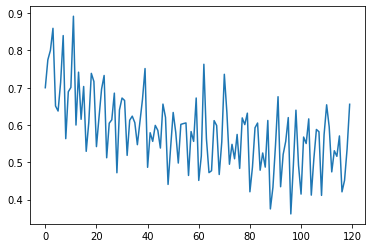

In [37]:
fig, ax = plt.subplots()
ax.plot(train_loss)
plt.show()

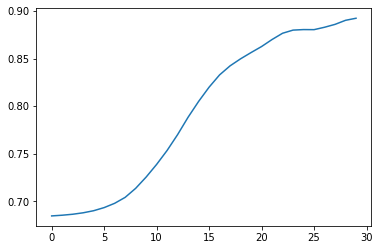

In [38]:
fig, ax = plt.subplots()
ax.plot(eval_loss)
plt.show()

# SVM =======================

In [41]:
from sklearn import svm

In [64]:
for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVC(kernel=kern)
    
    train_feat = np.concatenate([train_k_dvs-train_u_dvs, train_dists[:,None]], axis=1)
    clf.fit( train_feat, train_y )
    
    eval_feat = np.concatenate([eval_k_dvs-eval_u_dvs, eval_dists[:,None]], axis=1)
    pred_y = clf.predict( eval_feat )
    
    correct = pred_y == eval_y
    acc = sum(correct) / len(correct)
    print("kernel: " + kern + " acc: " + str(acc))

kernel: linear acc: 0.4666666666666667
kernel: poly acc: 0.4666666666666667
kernel: rbf acc: 0.6666666666666666
kernel: sigmoid acc: 0.5
